Plots: GO proposed AGN on K2 FOV

In [78]:
from analysis import *
import math

from astropy.io import fits
import K2fov

import warnings
warnings.filterwarnings('ignore')

# all the campaigns we've requested objects in/want to look at
#campaigns = [0, 1, 5, 8, 10, 12, 14, 16, 18, 19]

from matplotlib import colors
import richardsplot

In [75]:
# load the MADs values (calculated in plots_FOC_MAD.ipynb)
MADs = np.load('MADS_C8_C16_median.npy')

In [79]:
def rotate_and_center(ras, decs, fov):
    """
    Rotates and centers K2 objects
    """
    angle = math.radians(-fov.roll0_deg)
    
    # cos dec 
    # diff bwteen two RA
    
    ras_cor =  math.cos(angle)*(ras-fov.ra0_deg)*math.cos(math.radians(fov.dec0_deg))\
        - math.sin(angle)*(decs-fov.dec0_deg)
    decs_cor = math.sin(angle) * (ras-fov.ra0_deg)*math.cos(math.radians(fov.dec0_deg))\
        + math.cos(angle) * (decs-fov.dec0_deg)

    return ras_cor, decs_cor

def plot_fov(fov, ax, mads=None):
    """
    Plot the k2 fov without rotation
        - fov.plotPointing()
        - Projection.plot()
        - skyToPix(ra_deg, dec_deg) # returns ra, dec
        
    """
    if mads is not None:
        # create colorbar
        cmap = plt.cm.cool
        norm = colors.Normalize(vmin=np.nanmin(mads), vmax=np.nanmax(mads))
    
    colour='blue'
    mod3 = 'red'
    
    radec = fov.currentRaDec
    for ch in radec[:,2][::4]:

        idx = np.where(radec[:,2].astype(np.int) == ch)[0]
        idx = np.append(idx, idx[0])  #% points to draw a box

        if ch in fov.brokenChannels: 
            c = mod3 # bad module color
            
        elif (mads is not None) and (np.isin(ch,np.arange(1,85))):
            c = cmap(norm(mads[int(ch-1)]))
        else:
            c = colour # good module color
            
            
        new_ra, new_dec = rotate_and_center(radec[idx, 3], radec[idx, 4], fov)
        ax.plot(-new_ra, new_dec, '-', linewidth=4, color=c)# plot it


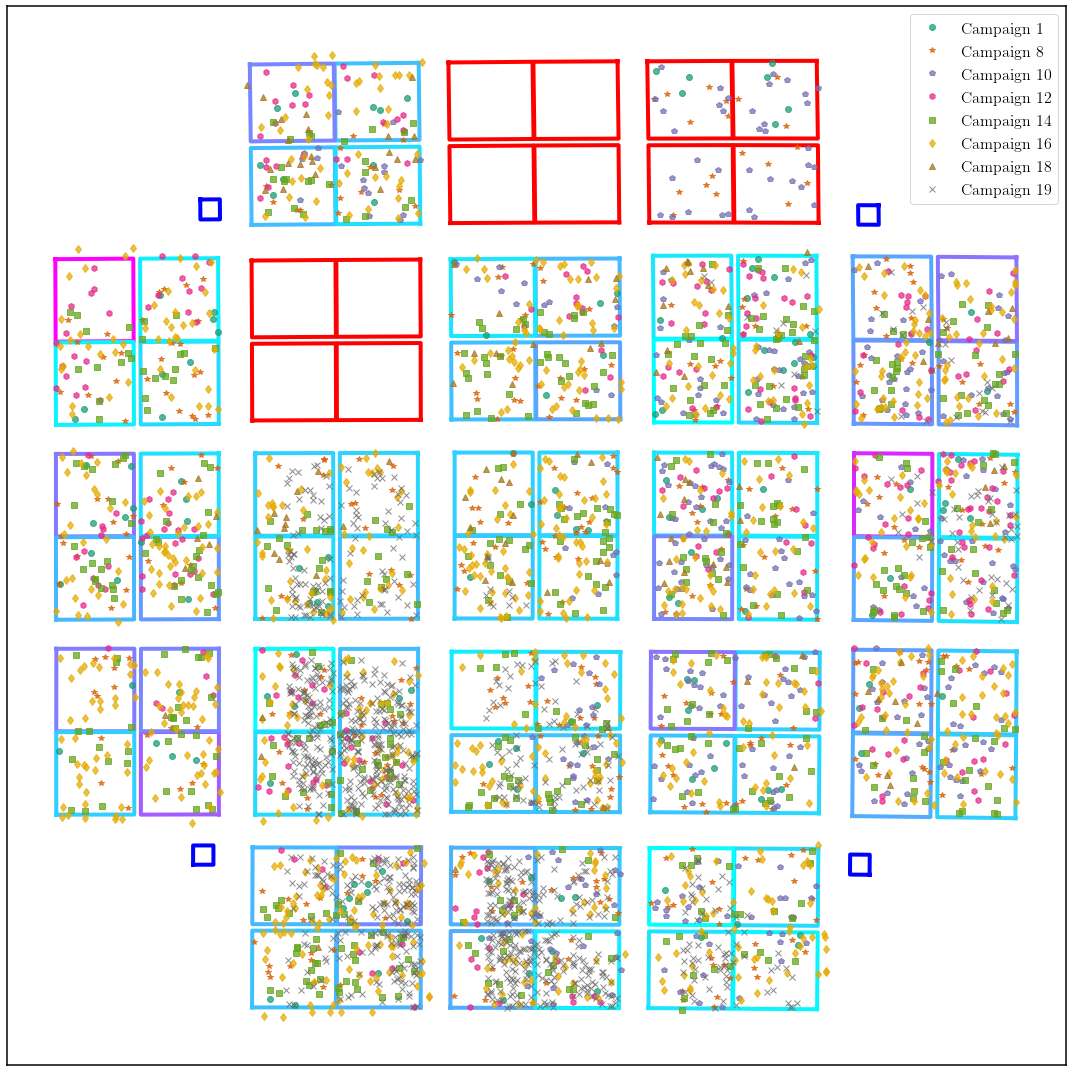

In [102]:
plt.figure(figsize=(15,15))
plot_fov(K2fov.getKeplerFov(fieldnum=19), plt, mads=MADs)

# all the campaigns we've requested objects in/want to look at
campaigns = [1, 8, 10, 12, 14, 16, 18, 19]

# make my life easier
path = 'K2_all_AGN_targets/'
fnames = ["GO1035-targets.csv", 'GO8052-targets.withz.fits', 'GO10052-targets.withz.fits', 'GO12013-targets.withz.fits', 'GO14088-targets.wzspec.fits', 
          'GO16088-targets.wzspec.fits', 'GO18044-targets.wzspec.fits', 'GO19044-targets.wzspec.fits']

marker_colors = ["#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e","#e6ab02","#a6761d","#666666"]
markers = ['o', '*', 'p', 'h', 's','d', '^', 'x']#, 'v']

# loop thru the campaigns
for campaign, fname, c, m in zip(campaigns, fnames, marker_colors, markers):
    fov = K2fov.getKeplerFov(fieldnum=campaign)
    
    if campaign==1:
        df = pd.read_csv("K2_official_targets/GO1035-targets.csv", skipinitialspace=True)
        ra = np.array(df['RA (J2000) [deg]'])
        dec = np.array(df['Dec (J2000) [deg]'])
    else:
        with fits.open(path+fname) as f:
            ra = np.array(f['Joined'].data[f['Joined'].columns[1].name])
            dec = np.array(f['Joined'].data[f['Joined'].columns[2].name])

    ras,decs = rotate_and_center(ra,dec, fov)
    plt.plot(-ras, decs,marker=m, ls='', alpha=0.75, color=c, label="Campaign %s"%campaign)
    
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=16)
#plt.title("AGN in K2 Field of View", fontsize=20)
plt.tight_layout()
plt.savefig("submit/K2_FOV_AGN_MADcolored.pdf")

This image was generate by rotating K2fov plots, so there is some offset

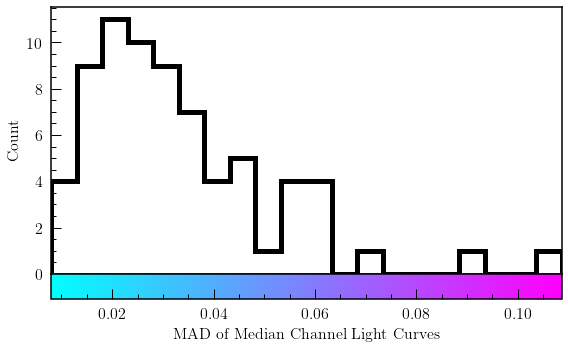

In [111]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

# hist
ax.hist(MADs, bins=20, histtype=u'step',linewidth=5, color='k')
ax.margins(x=0)
ax.set_ylabel("Count", fontsize=16)
ax.set_xticks([])
cmap = plt.cm.cool
norm = colors.Normalize(vmin=np.nanmin(MADs), vmax=np.nanmax(MADs))

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation="horizontal", pad = 0.0)
cbar.ax.set_xlabel("MAD of Median Channel Light Curves", fontsize=16)

plt.tight_layout()
plt.savefig('submit/K2_MAD_hist.pdf')